In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os, sys
from mpl_toolkits.axes_grid1 import make_axes_locatable
from sklearn.manifold import TSNE
font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : 14}

plt.rc('font', **font)
import warnings
warnings.filterwarnings('ignore')

In [2]:
def sigmoid(x):
    return np.where(x >= 0, 
                    1 / (1 + np.exp(-x)), 
                    np.exp(x) / (1 + np.exp(x)))

Toy data generating mechanism:

Fix $\sigma,\rho \in \mathbb{R}$ and $p\in \mathbb{N}$.

Fix $\beta_0,\beta_\tau \in \mathbb{R}^p$, such that $||\beta_0||_0 = ||\beta_\tau||_0 = p^* <<p$, and $supp(\beta_0)=supp(\beta_\tau)$

Fix $\gamma \in \mathbb{R}^p$ such that $||\gamma||_0= p^* << p$


Draw $X_i,T_i, Y_i$ as follows:

$$ X_i \sim \mathcal{MVN}(0,\sigma^2 [(1-\rho)I_p + \rho 1_p1_p^T])$$

$$ P(T_i=1|X_i) = \sigma(X\gamma)$$

$$\epsilon_i \sim \mathcal{N}(0,1)$$
$$Y_i(0) = X_i\beta_0 + \epsilon_i $$
$$Y_i(1) = Y_i(0) + X_i\beta_\tau + \epsilon_i $$

When $||\gamma||_0 = 0$, then $P(X_i|T_i=0)=P(X_i|T_i=1)$. In this case, the propensity score estimator will perform poorly, and a propensity-based weighted regression should perform worse than/equal to an unweighted regression.

As $||\gamma||_0$ increases, the distance between the distributions $P(X_i|T_i=0)$ and $P(X_i|T_i=1)$ will increase, and so too should the benefit of using a propensity weighted regression.

In [3]:
from sklearn.model_selection import train_test_split
def high_dim_simu(p=3000, n=1500, gamma_val=1, rho=0.3, var=2, k=30, h_degree=0.1,true_ate=0,scenario="A", n_copy=100,seed=123):
    np.random.seed(seed)
    x = np.zeros([n, p, n_copy])
    t = np.zeros([n, n_copy])
    yf = np.zeros([n, n_copy])
    ycf = np.zeros([n, n_copy])
    mu1 = np.zeros([n, n_copy])
    mu0 = np.zeros([n, n_copy])

    # Can change these to random normal if needed
    first_half = np.ones(int(np.ceil(float(k) / 2))) # ceil and floor to deal with odd k
    second_half = np.ones(int(np.floor(float(k) / 2)))
    
    first_half_tau = np.ones(int(np.ceil(float(k) / 2)))
    second_half_tau = np.ones(int(np.floor(float(k) / 2)))
    
    
    first_half_gamma = gamma_val*np.ones(int(np.ceil(float(k) / 2)))
    second_half_gamma = gamma_val*np.ones(int(np.floor(float(k) / 2)))

    for i in range(n_copy):
        mean_vec = np.zeros(p)
        if scenario == "A":
            beta = np.concatenate((first_half, second_half, np.zeros(p - k)))
            beta_tau = h_degree*np.concatenate((first_half_tau, second_half_tau, np.zeros(p - k)))
            gamma = np.concatenate((first_half_gamma, second_half_gamma, np.zeros(p - k)))
        elif scenario == "B":
            beta = np.concatenate((first_half, second_half, np.zeros(p - k)))
            beta_tau = h_degree*np.concatenate((first_half_tau, second_half_tau, np.zeros(p - k)))
#             print(k,p)
#             print(type(k//2),type(p-k-k//2))
            gamma = np.concatenate((first_half_gamma, np.zeros(k//2), second_half_gamma, np.zeros(p - k - k//2)))
        else:
            beta = np.concatenate((np.zeros(p - k), first_half, second_half))
            beta_tau = h_degree*np.concatenate((np.zeros(p - k), first_half_tau, second_half_tau))
            gamma = np.concatenate((first_half_gamma, second_half_gamma, np.zeros(p - k)))

        Sigma_x = (np.ones([p, p]) * rho + np.identity(p) * (1 - rho)) * var

        x[:, :, i] = np.random.multivariate_normal(mean_vec, Sigma_x, n)
        prob_t = sigmoid(x[:, :, i].dot(gamma))
        t[:, i] = np.random.binomial(1, prob_t, size=n)

        mu0[:, i] = np.matmul(x[:, :, i], beta)
        mu1[:, i] = mu0[:, i] + np.matmul(x[:, :, i], beta_tau)+true_ate
        if i == 0:
            ate = np.mean(mu1[:, i] - mu0[:, i])
            t_id = np.where(t[:, i] == 1)
            att = np.mean(mu1[t_id, i] - mu0[t_id, i])
        noise = np.random.normal(size=n)
        yf[:, i] = t[:, i] * mu1[:, i] + (1 - t[:, i]) * mu0[:, i] + noise
        ycf[:, i] = t[:, i] * mu0[:, i] + (1 - t[:, i]) * mu1[:, i] + noise
#         if i%10==0:
#             print (i, "th finished")
    
    
    return {'x': x, 't': t, 'mu0': mu0, 'mu1': mu1, 'yf': yf, 'ycf': ycf, 'ate': true_ate, 'att': att}

# Test the train/test split function

In [4]:
def train_test_split_custom(data,test_size=0.25,seed=123):
    from sklearn.model_selection import StratifiedShuffleSplit
    n_copy = data['x'].shape[2]
    sss = StratifiedShuffleSplit(n_splits=1, test_size=0.25, random_state=123)
    train,test = next(sss.split(data['x'][:,:,0],data['t'][:,0]))
    
    # Initialize variables
    data_train={}
    data_test={}
    data_train['x'] = np.zeros((len(train),data['x'].shape[1],data['x'].shape[2]))
    data_test['x'] = np.zeros((len(test),data['x'].shape[1],data['x'].shape[2]))
    
    for var in ['t','mu0','mu1','yf','ycf']:
        data_train[var] = np.zeros((len(train),data[var].shape[1]))
        data_test[var] = np.zeros((len(test),data[var].shape[1]))
    
    # Loop over repetitions
    for i in range(n_copy):
        sss = StratifiedShuffleSplit(n_splits=1, test_size=0.25, random_state=seed)
        train,test = next(sss.split(data['x'][:,:,i],data['t'][:,i]))
        
        data_train['x'][:,:,i] = data['x'][train,:,i]
        data_test['x'][:,:,i] = data['x'][test,:,i]
        
        for var in ['t','mu0','mu1','yf','ycf']:
            data_train[var][:,i] = data[var][train,i]
            data_test[var][:,i] = data[var][test,i]
        
        if(i==0):
            
            t_id_train = np.where(data_train['t']==1)
            t_id_test = np.where(data_test['t']==1)
            data_train['att'] = np.mean(data_train['mu1'][t_id_train,i]-data_train['mu0'][t_id_train,i])
            data_test['att'] = np.mean(data_test['mu1'][t_id_test,i]-data_test['mu0'][t_id_test,i])
        
    data_train['ate'] = data['ate']
    data_test['ate'] = data['ate']
            
    return data_train,data_test

In [5]:
p=25 # data dimension
p_star = 10 #number of dimensions determining outcomes & treatment
n=1000 # number of data points
n_copy= 20 # number of repetitions
rho = 0.3 # correlation between features
var = 2 # variance of feature vectors
gamma_val = 5
SNR = 1 #Signal-to-noise ratio
var = SNR/p_star # variance of feature vectors
sc = 'A'
h_degree=0.3
tau=3

data = high_dim_simu(p=p, n=n, rho=rho, gamma_val = gamma_val,var=var,k=p_star, h_degree=h_degree, true_ate=tau, scenario=sc, n_copy=n_copy)

In [6]:
data_train,data_test = train_test_split_custom(data)

# Save all datasets

In [9]:
# Create directories
save_dir = 'toy_data_SNR_2'
gammas = np.linspace(0,5,11)
scenarios = ['A','B','C']
SNRs = [1.0]
if(not os.path.exists('../datasets/'+save_dir)):
    os.mkdir('../datasets/'+save_dir)
for SNR in SNRs:
    for gamma_val in gammas:
        for sc in scenarios:
            name = '../datasets/'+save_dir+'/{:s}_{:.1f}_{:.2f}'.format(sc,gamma_val,SNR)
            if(not os.path.exists(name)):
                os.mkdir(name)

In [10]:
p=50 # data dimension
p_star = 20 #number of dimensions determining outcomes & treatment
n=1000 # number of data points
n_copy= 20 # number of repetitions
rho = 0.3 # correlation between features
h_degree=0.3 # size of beta_tau
tau=3 # true ATE
for SNR in SNRs:
    var = SNR/p_star # variance of feature vectors
    for gamma_val in gammas:
        for sc in scenarios:
            data = high_dim_simu(p=p, n=n, rho=rho, gamma_val = gamma_val,var=var, k=p_star, h_degree=h_degree, true_ate=tau, scenario=sc, n_copy=n_copy)
            data_train,data_test = train_test_split_custom(data,test_size=0.25,seed=123)
            np.savez('../datasets/'+save_dir+'/{:s}_{:.1f}_{:.2f}/data_train.npz'.format(sc,gamma_val,SNR),**data_train)
            np.savez('../datasets/'+save_dir+'/{:s}_{:.1f}_{:.2f}/data_test.npz'.format(sc,gamma_val,SNR),**data_test)

# TSNE visualization of effect of gamma

<Figure size 648x216 with 0 Axes>

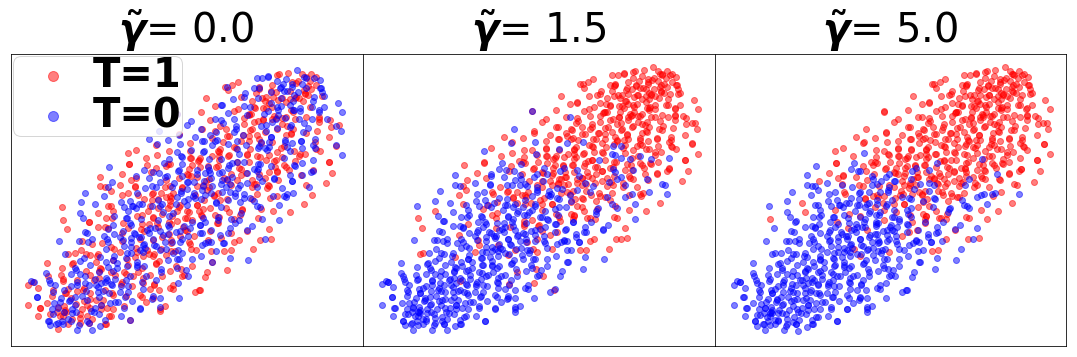

In [11]:
SMALL_SIZE = 8
MEDIUM_SIZE = 20
BIGGER_SIZE = 30

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=MEDIUM_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

np.random.seed(123)
n = 1000
p = 50
rho = 0.3
SNR = 1.0
p_star = 20
k = p_star
var = SNR/p_star
mean_vec = np.zeros(p)
Sigma_x = (np.ones([p, p]) * rho + np.identity(p) * (1 - rho)) * var
x = np.random.multivariate_normal(mean_vec, Sigma_x, n)
x_emb = TSNE(n_components=2,random_state=123).fit_transform(x)
t_all = []
plt.figure(figsize=(9,3))
fig,axes= plt.subplots(nrows=1,ncols=3, figsize=(15,5))
for i,gamma_val in enumerate([0.0,1.5,5.0]):
    first_half_gamma = gamma_val*np.ones(int(np.ceil(float(k) / 2)))
    second_half_gamma = gamma_val*np.ones(int(np.floor(float(k) / 2)))
    gamma = np.concatenate((first_half_gamma, second_half_gamma, np.zeros(p - k)))
    prob_t = sigmoid(x.dot(gamma))
    t = np.random.binomial(1, prob_t, size=n)
    t_all.append(t)
#     plt.subplot(3,1,i+1)
    axes[i].set_title(r'$\tilde{\gamma}$'+'= {}'.format(gamma_val),size=40,y=1.02)
    axes[i].scatter(x_emb[t==1,0],x_emb[t==1,1],color='r',marker='o',label='T=1',alpha=0.5)
    axes[i].scatter(x_emb[t==0,0],x_emb[t==0,1],color='b',marker='o',label='T=0',alpha=0.5)
    axes[i].set_xticks([])
    axes[i].set_yticks([])
lgnd = axes[0].legend(fontsize=40,handletextpad=0,borderpad=0.0,labelspacing=0.0,loc='upper left',bbox_to_anchor=(-0.05, 1.06))
for handle in lgnd.legendHandles:
    handle.set_sizes([100])
plt.tight_layout()
plt.subplots_adjust(wspace=0, hspace=0)
plt.savefig('TSNE_gammas.png')